In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from torch.utils.tensorboard import SummaryWriter

#### Preprocessing the data

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
import glob
import rasterio
import rioxarray
import xarray as xr
from PIL import Image
import warnings
import datetime
warnings.filterwarnings('ignore')
from sklearn.metrics import roc_auc_score

In [3]:
from collections import Counter
def check_size_most(img_path):
    ''' Finding the most occuring size of the image in the dataset'''
    # img_path = glob.glob(img_path)
    img_size = []
    for i in img_path:
        try:
            img = rioxarray.open_rasterio(i)
            img_size.append(img.shape)
        except:
            pass
    return Counter(img_size).most_common(1).pop()[0]
    
def clean_data_by_size(img_path):
    img_path = glob.glob(img_path, recursive=True)
    print("Initial size of dataset", len(img_path))
    size= check_size_most(img_path)
    print("Most common size of the dataset", size)
    #delete the images from img_path list which are not of the most common size
    for i in img_path:
        try:
            img = rioxarray.open_rasterio(i)
            if img.shape != size:
                img_path.remove(i)
        except:
            pass
    print("Final size of dataset(after removing faulty size images)", len(img_path))
    return img_path

def clean_data_by_black_pixels(img_path_list):
    black_pixels = []
    for i in img_path_list:
        try:
            img = rioxarray.open_rasterio(i)
            black_pixels.append(np.count_nonzero(img.data[0:3].transpose(1, 2, 0) == 0))
        except:
            pass
    img_path_median = []
    for i in range(len(img_path_list)):
        try: 
            if black_pixels[i] <= np.median(black_pixels):
                img_path_median.append(img_path_list[i])
        except:
            pass
    print("Final size of dataset(after removing faulty black pixels in images)", len(img_path_median))
    return img_path_median

def clean_data_by_white_pixels(img_path_list, threshold=200):
    white_pixels = []
    for i in img_path_list:
        try: 
            img = rioxarray.open_rasterio(i)
            white_pixels.append(np.count_nonzero(img.data[0:3].transpose(1, 2, 0)  >= threshold))
        except:
            pass

    img_path_mean_white = []
    for i in range(len(img_path_list)):
        try:
            if white_pixels[i] <= np.mean(white_pixels):
                img_path_mean_white.append(img_path_list[i])
        except:
            pass
    print("Final size of dataset(after removing faulty white pixels in images)", len(img_path_mean_white))
    return img_path_mean_white



def find_day(date_string):
    try:
        date = datetime.datetime.strptime(date_string, "%Y-%m-%d")
        day = date.strftime("%A")
        return day
    except ValueError:
        return "Invalid date format. Please provide the date in YYYY-MM-DD format."
    

# def label_csv(clean_img_path):
#     df = pd.DataFrame(columns=['image_path', 'day'])
#     for i in clean_img_path:
#         date_in = i.split('/')[-1].split('_')[0]
#         year = date_in[0:4]
#         month = date_in[4:6]
#         day = date_in[6:8]
#         date_string = f"{year}-{month}-{day}"
#         df = df.append({'image_path': i, 'day': find_day(date_string)}, ignore_index=True)
#     df['label'] = df['day'].apply(lambda x: 1 if x in ['Sunday'] else 0)
#     print("Class distribution in dataset:", df.label.value_counts())
#     return df

def label_csv(clean_img_path):
    df = pd.DataFrame(columns=['image_path', 'day'])
    for j in clean_img_path:
        for i in j:
            date_in = i.split('/')[-1].split('_')[0]
            year = date_in[0:4]
            month = date_in[4:6]
            day = date_in[6:8]
            date_string = f"{year}-{month}-{day}"
            df = df.append({'image_path': i, 'day': find_day(date_string)}, ignore_index=True)
    df['label'] = df['day'].apply(lambda x: 1 if x in ['Sunday'] else 0)
    print("Class distribution in dataset:", df.label.value_counts())
    return df


def create_median_image(images_path):

    first_img = rioxarray.open_rasterio(images_path[0])

    width, height = first_img.data[0:3].transpose(1, 2, 0).shape[0:2]
    num_images = len(images_path)

    red_values = np.zeros(( width,height, num_images), dtype=np.uint8)
    green_values = np.zeros(( width,height, num_images), dtype=np.uint8)
    blue_values = np.zeros(( width,height, num_images), dtype=np.uint8)


    for i,j in enumerate(images_path):
        
        try:
            img = rioxarray.open_rasterio(j).data[0:3].transpose(1, 2, 0)
            red_values[:, :, i], green_values[:, :, i], blue_values[:, :, i] = img[:, :, 0], img[:, :, 1], img[:, :, 2]
        except:
            pass
    
    red_median = np.median(red_values, axis=2)
    green_median = np.median(green_values, axis=2)
    blue_median = np.median(blue_values, axis=2)
    img_arr = np.uint8(np.dstack((red_median, green_median, blue_median)))
    median_image = Image.fromarray(img_arr)
    
    return img_arr, median_image


In [4]:
data_path_list = os.listdir("/home/akansh-i2sc/Desktop/Study/detect-car-LR/data/parking_lot_data")

In [5]:
#create a random integer list
import random
a = [i for i in range(0, len(data_path_list))]
random.shuffle(a)
train = [data_path_list[i] for i in a[:int(len(a)*0.8)]] #80% of data
test = [data_path_list[i] for i in a[int(len(a)*0.8):]] #20% of data

In [6]:
base_path = "/home/akansh-i2sc/Desktop/Study/detect-car-LR/data/"
train_images_paths = []
for i in train:
    train_images_paths.append(os.path.join(base_path, i + "/**/*.tif"))

test_images_paths = []
for i in test:
    test_images_paths.append(os.path.join(base_path, i + "/**/*.tif"))

final_train_images_paths = []
for i in train_images_paths:
    clean_1 = clean_data_by_size(i)
    clean_2 = clean_data_by_black_pixels(clean_1)
    clean_3 = clean_data_by_white_pixels(clean_2)
    final_train_images_paths.append(clean_3)

final_test_images_paths = []
for i in test_images_paths:
    clean_1 = clean_data_by_size(i)
    clean_2 = clean_data_by_black_pixels(clean_1)
    clean_3 = clean_data_by_white_pixels(clean_2)
    final_test_images_paths.append(clean_3)


Initial size of dataset 500
Most common size of the dataset (4, 75, 67)
Final size of dataset(after removing faulty size images) 498
Final size of dataset(after removing faulty black pixels in images) 462
Final size of dataset(after removing faulty white pixels in images) 449
Initial size of dataset 500
Most common size of the dataset (4, 52, 63)
Final size of dataset(after removing faulty size images) 500
Final size of dataset(after removing faulty black pixels in images) 479
Final size of dataset(after removing faulty white pixels in images) 416
Initial size of dataset 500
Most common size of the dataset (4, 63, 70)
Final size of dataset(after removing faulty size images) 499
Final size of dataset(after removing faulty black pixels in images) 476
Final size of dataset(after removing faulty white pixels in images) 182
Initial size of dataset 500
Most common size of the dataset (4, 64, 61)
Final size of dataset(after removing faulty size images) 500
Final size of dataset(after removing

(-0.5, 63.5, 42.5, -0.5)

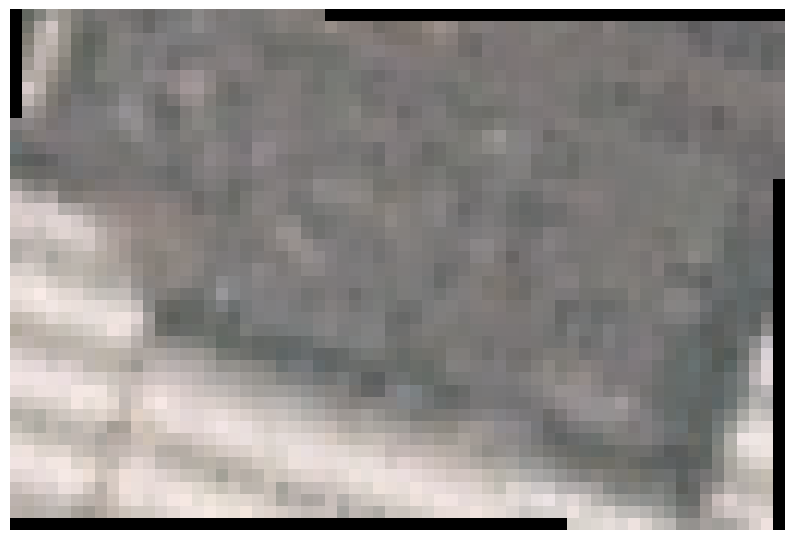

In [8]:
#plot single random image
plt.figure(figsize=(10,10))
img = rioxarray.open_rasterio(clean_3[0])
plt.imshow(img.data[0:3].transpose(1, 2, 0))
plt.axis('off')

(-0.5, 63.5, 42.5, -0.5)

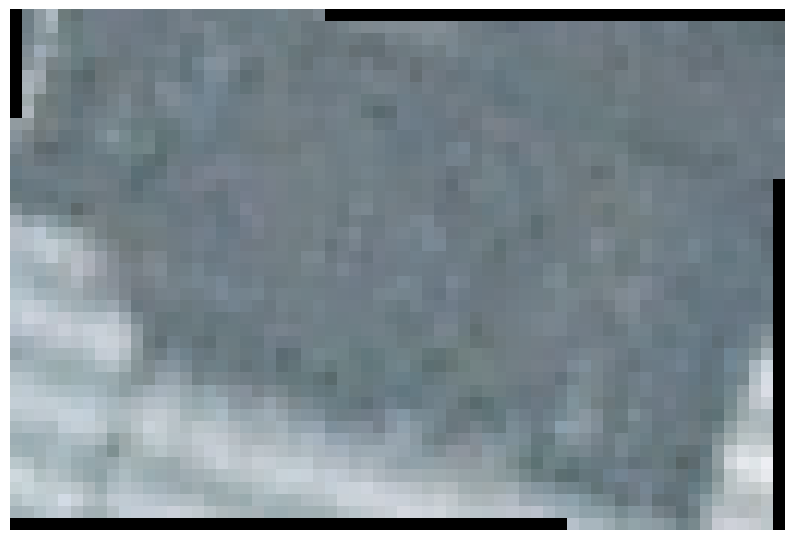

In [10]:
#plot single random image
plt.figure(figsize=(10,10))
img = rioxarray.open_rasterio(clean_3[47])
plt.imshow(img.data[0:3].transpose(1, 2, 0))
plt.axis('off')

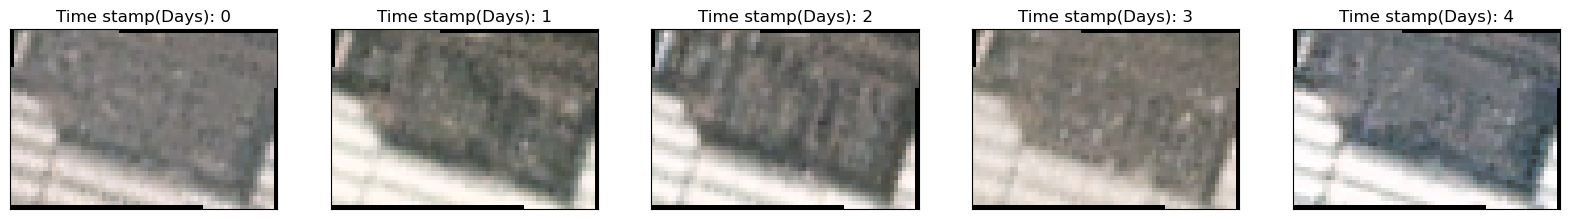

In [11]:
#plot random 5 images from clean_3 list
plt.figure(figsize=(20,20))
for i in range(5):
    plt.subplot(1,5,i+1)
    img = rioxarray.open_rasterio(clean_3[i])
    plt.imshow(img.data[0:3].transpose(1, 2, 0))
    plt.title(f'Time stamp(Days): {i}')
    plt.xticks([])
    plt.yticks([])


In [12]:
# plt.figure(figsize=(20,20))
# for i in range(len(clean_3)):
#     plt.subplot(30,30,i+1)
#     img = rioxarray.open_rasterio(clean_3[i])
#     plt.imshow(img.data[0:3].transpose(1, 2, 0))
#     plt.axis('off')

#### Create and save median images

In [13]:
median_image, _ = create_median_image(final_train_images_paths[0])
path = "/"
for j in range(len(final_train_images_paths)):
    median_image, _ = create_median_image(final_train_images_paths[j])
    path = "/"
    for i in final_train_images_paths[j][0].split('/')[1:-2]:
        path = os.path.join(path, i)
    np.save(os.path.join(path, 'median_image.npy'), median_image)

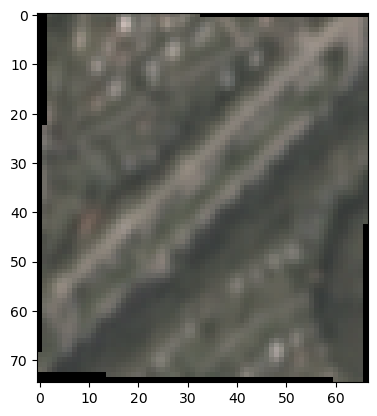

In [14]:
median_image, _ = create_median_image(final_train_images_paths[0])
plt.imshow(median_image)

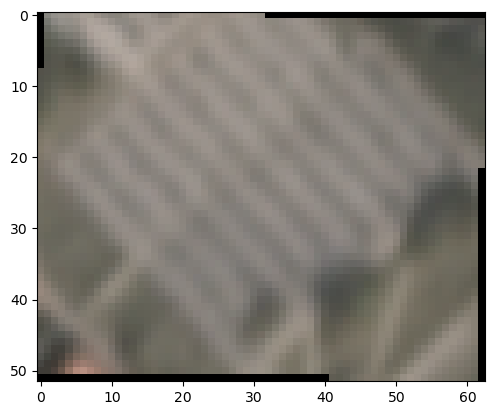

In [15]:
median_image, _ = create_median_image(final_train_images_paths[1])
plt.imshow(median_image)

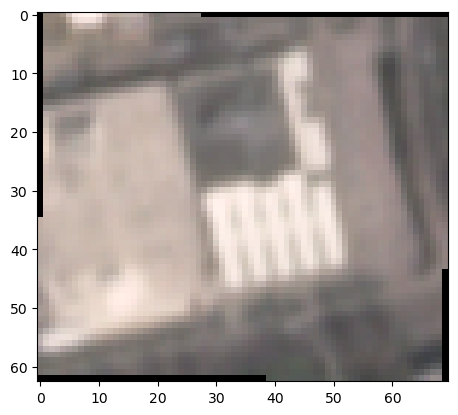

In [16]:
median_image, _ = create_median_image(final_train_images_paths[2])
plt.imshow(median_image)

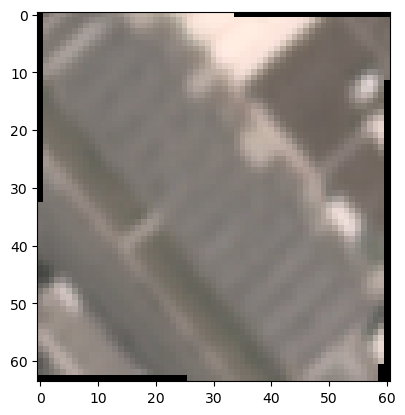

In [17]:
median_image, _ = create_median_image(final_train_images_paths[3])
plt.imshow(median_image)

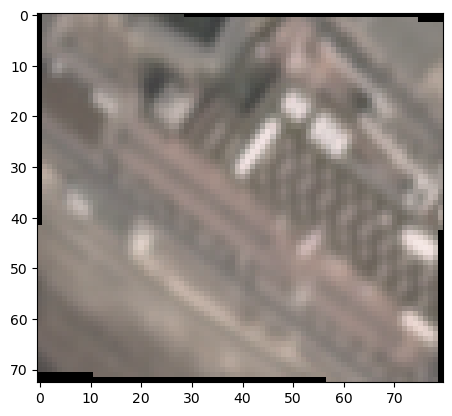

In [14]:
median_image, _ = create_median_image(final_train_images_paths[3])
plt.imshow(median_image)

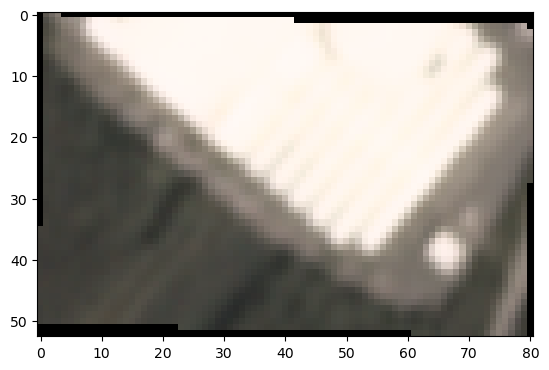

In [18]:
median_image, _ = create_median_image(final_train_images_paths[4])
plt.imshow(median_image)

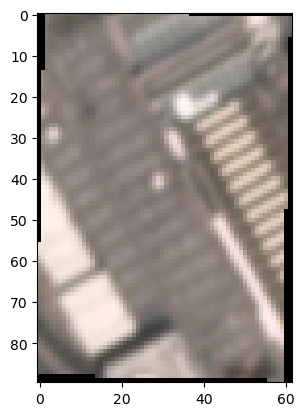

In [20]:
median_image, _ = create_median_image(final_train_images_paths[5])
plt.imshow(median_image)

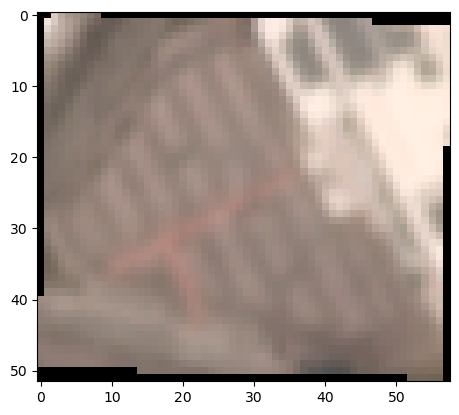

In [21]:
median_image, _ = create_median_image(final_train_images_paths[6])
plt.imshow(median_image)

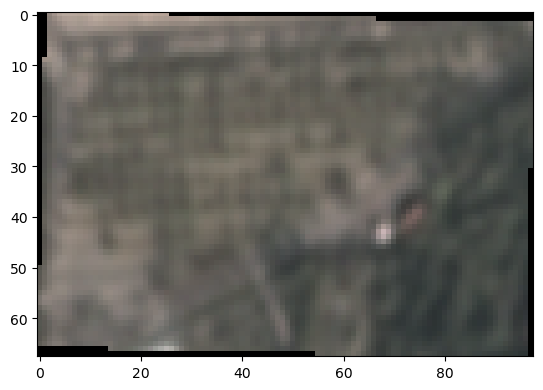

In [22]:
median_image, _ = create_median_image(final_train_images_paths[7])
plt.imshow(median_image)

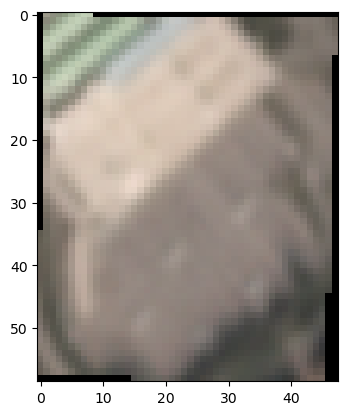

In [23]:
median_image, _ = create_median_image(final_train_images_paths[8])
plt.imshow(median_image)

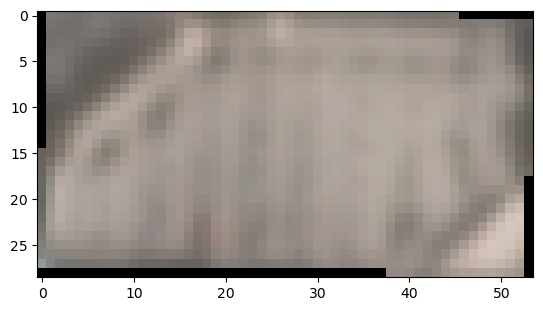

In [24]:
median_image, _ = create_median_image(final_train_images_paths[9])
plt.imshow(median_image)

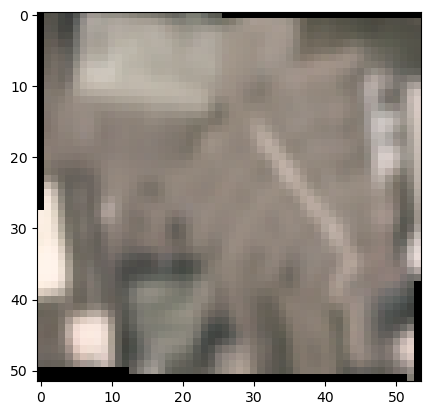

In [25]:
median_image, _ = create_median_image(final_train_images_paths[10])
plt.imshow(median_image)

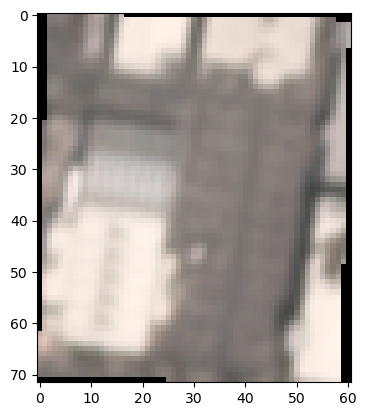

In [27]:
median_image, _ = create_median_image(final_train_images_paths[-1])
plt.imshow(median_image)

In [28]:
df_train = label_csv(final_train_images_paths)

Class distribution in dataset: 0    9498
1    1421
Name: label, dtype: int64


In [29]:
list_to_remove = []
for i in df_train.image_path:
    try:
        a = rioxarray.open_rasterio(i)
    except:
        list_to_remove.append(i)

df_train.image_path == list_to_remove[0]
df_train[df_train.image_path == list_to_remove[0]]
df_train.drop(df_train[df_train.image_path == list_to_remove[0]].index.values[0], inplace=True)

In [30]:
df_train.head()

,image_path,day,label
0,/home/akansh-i2sc/Desktop/Study/detect-car-LR/...,Thursday,0
1,/home/akansh-i2sc/Desktop/Study/detect-car-LR/...,Sunday,1
2,/home/akansh-i2sc/Desktop/Study/detect-car-LR/...,Saturday,0
3,/home/akansh-i2sc/Desktop/Study/detect-car-LR/...,Wednesday,0
4,/home/akansh-i2sc/Desktop/Study/detect-car-LR/...,Tuesday,0


In [31]:
df_test = label_csv(final_test_images_paths)

Class distribution in dataset: 0    2507
1     374
Name: label, dtype: int64


In [32]:
df_test.head()

,image_path,day,label
0,/home/akansh-i2sc/Desktop/Study/detect-car-LR/...,Monday,0
1,/home/akansh-i2sc/Desktop/Study/detect-car-LR/...,Tuesday,0
2,/home/akansh-i2sc/Desktop/Study/detect-car-LR/...,Friday,0
3,/home/akansh-i2sc/Desktop/Study/detect-car-LR/...,Wednesday,0
4,/home/akansh-i2sc/Desktop/Study/detect-car-LR/...,Wednesday,0


#### Custom pytorch dataset loader

In [36]:
# #pytorch dataset class for siamese network
# class SiameseNetworkDataset(Dataset):
#     def __init__(self, df, transform=None):
#         self.df = df
#         # self.median_img = median_img
#         self.transform = transform
#         self.median_img_transform = transforms.Compose([
#             transforms.ToPILImage(),
#             transforms.Resize((64, 64)),
#             transforms.ToTensor(),
#             transforms.Normalize(mean=[0.485, 0.456, 0.406], 
#                                  std=[0.229, 0.224, 0.225])
#         ])

#     def __getitem__(self, idx):
#         img_path = self.df.image_path.values[idx]
#         path = '/'
#         for i in df_train.image_path[0].split('/')[1:-2]:
#             path = os.path.join(path, i)

#         median_image = np.load(os.path.join(path, 'median_image.npy'))
#         img_1 = rioxarray.open_rasterio(img_path)
#         img_1 = img_1.data[0:3].transpose(1, 2, 0)
#         label = self.df.label.values[idx]
#         img_2 = self.median_img_transform(median_image)

#         if self.transform:
#             img_1 = self.transform(img_1)
#             # img_2 = self.transform(img_2) #median image augmentation, need experiments here. 
#         return img_1, img_2, label

#     def __len__(self):
#         return len(self.df)

class CustomDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        img_path = self.df.image_path.values[idx]
        img = rioxarray.open_rasterio(img_path)
        img = np.array(Image.fromarray(img.data[0:3].transpose(1, 2, 0)).resize((128,128)))
        label = self.df.label.values[idx]
        if self.transform:
            img = self.transform(img)
        return img, label
    
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=45),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225]),
])

test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225]),
])

train_dataset = CustomDataset(df_train, transform=train_transform)
test_dataset = CustomDataset(df_test, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [37]:
for x1,x2 in train_loader:
    print(x1.shape)
    print(x2.shape)
    break

torch.Size([32, 3, 128, 128])
torch.Size([32])


In [39]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torch.optim import Adam
from tqdm.auto import tqdm
import time
import copy

In [41]:
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.RandomVerticalFlip(p=0.2),
    transforms.RandomRotation(degrees=30),
    # transforms.RandomResizedCrop(size=128, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225]),
])


test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225]),
])

#dataset and dataloader
# train_dataset = SiameseNetworkDataset(df_train, transform=train_transform)
# test_dataset = SiameseNetworkDataset(df_test,  transform=test_transform)

# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)
# test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)


#### Model

In [42]:
# class SiameseNetwork(nn.Module):
#     def __init__(self):
#         super(SiameseNetwork, self).__init__()

#         self.resnet = models.resnet18(pretrained=True)  # Load pre-trained ResNet-18
#         self.resnet.fc = nn.Linear(512, 128)  # Change the fully connected layer to output 128-dimensional embeddings
#         self.fc1 = nn.Linear(128 * 2, 64)
#         self.fc2 = nn.Linear(64, 2)

#     def forward_one(self, x):
#         x = self.resnet(x)
#         return x

#     def forward(self, input1, input2):
#         output1 = self.forward_one(input1)
#         output2 = self.forward_one(input2)
#         combined = torch.cat((output1, output2), dim=1)
#         x = self.fc1(combined)
#         x = torch.relu(x)
#         x = self.fc2(x)
#         # x = torch.sigmoid(x)
#         return x


In [44]:
# resnet 18 model with pretrained weights
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

model = models.resnet18(pretrained=True)
for param in model.parameters():
    param.requires_grad = True
model.fc = nn.Linear(512, 2)
model = model.to(device)

cuda:0


In [45]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [46]:
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001)

In [50]:
# #training and validation, also calculating AUC scores for train and test set
# def train_model(model, criterion, optimizer, num_epochs=50):
#     train_loss = []
#     train_acc = []
#     train_auc = []
#     val_loss = []
#     val_acc = []
#     val_auc = []
#     writer = SummaryWriter()
#     best_model_wts = copy.deepcopy(model.state_dict())
#     best_acc = 0.0
#     best_auc = 0.0
#     for epoch in tqdm(range(num_epochs)):
#         print('Epoch {}/{}'.format(epoch, num_epochs - 1))
#         print('-' * 10)
#         since = time.time()
#         # Each epoch has a training and validation phase
#         for phase in ['train', 'test']:
#             if phase == 'train':
#                 model.train()  
#             else:
#                 model.eval()   
#             running_loss = 0.0
#             running_corrects = 0
#             y_pred = []
#             y_true = []
#             # Iterate over data.
#             for input_1, input_2, labels in eval(phase+'_loader'):
#                 input_1 = input_1.to(device)
#                 input_2 = input_2.to(device)
#                 labels = labels.to(device)
#                 # zero the parameter gradients
#                 optimizer.zero_grad()
#                 # forward
#                 # track history if only in train
#                 with torch.set_grad_enabled(phase == 'train'):
#                     # Get model outputs and calculate loss
#                     outputs = model(input_1, input_2)
#                     loss = criterion(outputs, labels)
#                     _, preds = torch.max(outputs, 1)
#                     # backward + optimize only if in training phase
#                     if phase == 'train':
#                         loss.backward()
#                         optimizer.step()
#                 # statistics
#                 running_loss += loss.item() * input_1.size(0)
                
#                 running_corrects += torch.sum(preds == labels.data)
#                 y_pred.extend(preds.cpu().numpy())
#                 y_true.extend(labels.cpu().numpy())
#             epoch_loss = running_loss / len(eval(phase+'_loader').dataset)
#             epoch_acc = running_corrects.double() / len(eval(phase+'_loader').dataset)
#             epoch_auc = roc_auc_score(y_true, y_pred)
#             writer.add_scalar(f'Loss/{phase}', epoch_loss, epoch)
#             writer.add_scalar(f'Accuracy/{phase}', epoch_acc, epoch)
#             writer.add_scalar(f'AUC/{phase}', epoch_auc, epoch)
#             print('{} Loss: {:.4f} Acc: {:.4f} AUC: {:.4f}'.format(
#                 phase, epoch_loss, epoch_acc, epoch_auc))
#             if phase == 'train':
#                 train_loss.append(epoch_loss)
#                 train_acc.append(epoch_acc)
#                 train_auc.append(epoch_auc)
#             else:
#                 val_loss.append(epoch_loss)
#                 val_acc.append(epoch_acc)
#                 val_auc.append(epoch_auc)
#             # deep copy the model
#             if phase == 'test' and epoch_auc > best_auc:
#                 best_acc = epoch_acc
#                 best_auc = epoch_auc
#                 best_model_wts = copy.deepcopy(model.state_dict())
#                 torch.save(model.state_dict(), '/home/akansh-i2sc/Desktop/Study/detect-car-LR/notebooks/Exp_4/models/exp_4.pt')
#         print()
#     time_elapsed = time.time() - since
#     print('Training complete in {:.0f}m {:.0f}s'.format(
#     time_elapsed // 60, time_elapsed % 60))
#     print('Best val Acc: {:4f}'.format(best_acc))
#     print('Best val AUC: {:4f}'.format(best_auc))
#     # load best model weights
#     model.load_state_dict(best_model_wts)
#     return model, train_loss, train_acc, val_loss, val_acc, train_auc, val_auc




In [51]:
def train_model(model, criterion, optimizer, num_epochs=10):
    train_loss = []
    train_acc = []
    train_auc = []
    val_loss = []
    val_acc = []
    val_auc = []
    writer = SummaryWriter()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_auc = 0.0
    for epoch in tqdm(range(num_epochs)):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        since = time.time()
        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  
            else:
                model.eval()   
            running_loss = 0.0
            running_corrects = 0
            y_pred = []
            y_true = []
            # Iterate over data.
            for inputs, labels in tqdm(eval(phase+'_loader')):
                inputs = inputs.to(device)
                labels = labels.to(device)
                # zero the parameter gradients
                optimizer.zero_grad()
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                y_pred.extend(preds.cpu().numpy())
                y_true.extend(labels.cpu().numpy())
            epoch_loss = running_loss / len(eval(phase+'_loader').dataset)
            epoch_acc = running_corrects.double() / len(eval(phase+'_loader').dataset)
            epoch_auc = roc_auc_score(y_true, y_pred)
            writer.add_scalar(f'Loss/{phase}', epoch_loss, epoch)
            writer.add_scalar(f'Accuracy/{phase}', epoch_acc, epoch)
            writer.add_scalar(f'AUC/{phase}', epoch_auc, epoch)

            print('{} Loss: {:.4f} Acc: {:.4f} AUC: {:.4f}'.format(
                phase, epoch_loss, epoch_acc, epoch_auc))
            if phase == 'train':
                train_loss.append(epoch_loss)
                train_acc.append(epoch_acc)
                train_auc.append(epoch_auc)
            else:
                val_loss.append(epoch_loss)
                val_acc.append(epoch_acc)
                val_auc.append(epoch_auc)
            # deep copy the model
            if phase == 'test' and epoch_auc > best_auc:
                best_acc = epoch_acc
                best_auc = epoch_auc
                best_model_wts = copy.deepcopy(model.state_dict())
                # torch.save(model.state_dict(), '/home/akansh-i2sc/Desktop/Research@societal/detect-car-LR/temp/models/model_mix_exp_3_1.pt')
        print()
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    print('Best val AUC: {:4f}'.format(best_auc))
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_loss, train_acc, val_loss, val_acc, train_auc, val_auc



In [52]:
model, train_loss, train_acc, val_loss, val_acc, train_auc, val_auc = train_model(model, criterion, optimizer, num_epochs=100)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 0/99
----------


  0%|          | 0/342 [00:00<?, ?it/s]

train Loss: 0.4058 Acc: 0.8671 AUC: 0.5002


  0%|          | 0/91 [00:00<?, ?it/s]

test Loss: 0.4053 Acc: 0.8702 AUC: 0.5000

Epoch 1/99
----------


  0%|          | 0/342 [00:00<?, ?it/s]

train Loss: 0.3967 Acc: 0.8686 AUC: 0.4996


  0%|          | 0/91 [00:00<?, ?it/s]

test Loss: 0.6441 Acc: 0.8702 AUC: 0.5000

Epoch 2/99
----------


  0%|          | 0/342 [00:00<?, ?it/s]

train Loss: 0.3931 Acc: 0.8684 AUC: 0.4998


  0%|          | 0/91 [00:00<?, ?it/s]

test Loss: 0.8940 Acc: 0.8702 AUC: 0.5000

Epoch 3/99
----------


  0%|          | 0/342 [00:00<?, ?it/s]

train Loss: 0.3911 Acc: 0.8688 AUC: 0.5000


  0%|          | 0/91 [00:00<?, ?it/s]

test Loss: 0.4470 Acc: 0.8702 AUC: 0.5000

Epoch 4/99
----------


  0%|          | 0/342 [00:00<?, ?it/s]

train Loss: 0.3880 Acc: 0.8687 AUC: 0.4994


  0%|          | 0/91 [00:00<?, ?it/s]

test Loss: 0.4090 Acc: 0.8646 AUC: 0.5002

Epoch 5/99
----------


  0%|          | 0/342 [00:00<?, ?it/s]

train Loss: 0.3878 Acc: 0.8698 AUC: 0.5000


  0%|          | 0/91 [00:00<?, ?it/s]

test Loss: 0.3852 Acc: 0.8702 AUC: 0.5000

Epoch 6/99
----------


  0%|          | 0/342 [00:00<?, ?it/s]

train Loss: 0.3863 Acc: 0.8687 AUC: 0.4996


  0%|          | 0/91 [00:00<?, ?it/s]

test Loss: 0.4352 Acc: 0.8702 AUC: 0.5000

Epoch 7/99
----------


  0%|          | 0/342 [00:00<?, ?it/s]

train Loss: 0.3888 Acc: 0.8692 AUC: 0.5002


  0%|          | 0/91 [00:00<?, ?it/s]

test Loss: 0.3848 Acc: 0.8702 AUC: 0.5000

Epoch 8/99
----------


  0%|          | 0/342 [00:00<?, ?it/s]

train Loss: 0.3906 Acc: 0.8690 AUC: 0.4995


  0%|          | 0/91 [00:00<?, ?it/s]

test Loss: 0.3830 Acc: 0.8702 AUC: 0.5000

Epoch 9/99
----------


  0%|          | 0/342 [00:00<?, ?it/s]

train Loss: 0.3903 Acc: 0.8682 AUC: 0.4999


  0%|          | 0/91 [00:00<?, ?it/s]

test Loss: 0.3787 Acc: 0.8702 AUC: 0.5000

Epoch 10/99
----------


  0%|          | 0/342 [00:00<?, ?it/s]

train Loss: 0.3849 Acc: 0.8698 AUC: 0.4999


  0%|          | 0/91 [00:00<?, ?it/s]

test Loss: 0.4008 Acc: 0.8702 AUC: 0.5000

Epoch 11/99
----------


  0%|          | 0/342 [00:00<?, ?it/s]

train Loss: 0.3910 Acc: 0.8698 AUC: 0.5002


  0%|          | 0/91 [00:00<?, ?it/s]

test Loss: 0.3858 Acc: 0.8702 AUC: 0.5000

Epoch 12/99
----------


  0%|          | 0/342 [00:00<?, ?it/s]

train Loss: 0.3929 Acc: 0.8678 AUC: 0.4994


  0%|          | 0/91 [00:00<?, ?it/s]

test Loss: 0.4222 Acc: 0.8702 AUC: 0.5000

Epoch 13/99
----------


  0%|          | 0/342 [00:00<?, ?it/s]

train Loss: 0.3864 Acc: 0.8696 AUC: 0.4998


  0%|          | 0/91 [00:00<?, ?it/s]

test Loss: 0.3842 Acc: 0.8702 AUC: 0.5000

Epoch 14/99
----------


  0%|          | 0/342 [00:00<?, ?it/s]

train Loss: 0.3855 Acc: 0.8692 AUC: 0.4996


  0%|          | 0/91 [00:00<?, ?it/s]

test Loss: 0.3935 Acc: 0.8702 AUC: 0.5000

Epoch 15/99
----------


  0%|          | 0/342 [00:00<?, ?it/s]

train Loss: 0.3827 Acc: 0.8697 AUC: 0.4999


  0%|          | 0/91 [00:00<?, ?it/s]

test Loss: 0.3933 Acc: 0.8702 AUC: 0.5000

Epoch 16/99
----------


  0%|          | 0/342 [00:00<?, ?it/s]

train Loss: 0.3864 Acc: 0.8687 AUC: 0.4996


  0%|          | 0/91 [00:00<?, ?it/s]

test Loss: 0.3856 Acc: 0.8702 AUC: 0.5000

Epoch 17/99
----------


  0%|          | 0/342 [00:00<?, ?it/s]

train Loss: 0.3832 Acc: 0.8691 AUC: 0.4996


  0%|          | 0/91 [00:00<?, ?it/s]

test Loss: 0.3806 Acc: 0.8702 AUC: 0.5000

Epoch 18/99
----------


  0%|          | 0/342 [00:00<?, ?it/s]

train Loss: 0.3794 Acc: 0.8697 AUC: 0.5011


  0%|          | 0/91 [00:00<?, ?it/s]

test Loss: 0.3908 Acc: 0.8702 AUC: 0.5000

Epoch 19/99
----------


  0%|          | 0/342 [00:00<?, ?it/s]

train Loss: 0.3883 Acc: 0.8694 AUC: 0.5000


  0%|          | 0/91 [00:00<?, ?it/s]

test Loss: 0.3859 Acc: 0.8702 AUC: 0.5000

Epoch 20/99
----------


  0%|          | 0/342 [00:00<?, ?it/s]

train Loss: 0.3813 Acc: 0.8697 AUC: 0.5002


  0%|          | 0/91 [00:00<?, ?it/s]

test Loss: 0.3871 Acc: 0.8702 AUC: 0.5000

Epoch 21/99
----------


  0%|          | 0/342 [00:00<?, ?it/s]

train Loss: 0.3770 Acc: 0.8695 AUC: 0.5004


  0%|          | 0/91 [00:00<?, ?it/s]

test Loss: 0.4075 Acc: 0.8702 AUC: 0.5000

Epoch 22/99
----------


  0%|          | 0/342 [00:00<?, ?it/s]

train Loss: 0.3727 Acc: 0.8690 AUC: 0.4998


  0%|          | 0/91 [00:00<?, ?it/s]

test Loss: 0.3835 Acc: 0.8702 AUC: 0.5000

Epoch 23/99
----------


  0%|          | 0/342 [00:00<?, ?it/s]

train Loss: 0.3691 Acc: 0.8707 AUC: 0.5077


  0%|          | 0/91 [00:00<?, ?it/s]

test Loss: 0.4018 Acc: 0.8702 AUC: 0.5000

Epoch 24/99
----------


  0%|          | 0/342 [00:00<?, ?it/s]

train Loss: 0.3685 Acc: 0.8699 AUC: 0.5054


  0%|          | 0/91 [00:00<?, ?it/s]

test Loss: 0.3927 Acc: 0.8560 AUC: 0.4975

Epoch 25/99
----------


  0%|          | 0/342 [00:00<?, ?it/s]

train Loss: 0.3618 Acc: 0.8718 AUC: 0.5182


  0%|          | 0/91 [00:00<?, ?it/s]

test Loss: 0.4032 Acc: 0.8466 AUC: 0.5046

Epoch 26/99
----------


  0%|          | 0/342 [00:00<?, ?it/s]

train Loss: 0.3588 Acc: 0.8720 AUC: 0.5260


  0%|          | 0/91 [00:00<?, ?it/s]

test Loss: 0.4150 Acc: 0.8414 AUC: 0.5153

Epoch 27/99
----------


  0%|          | 0/342 [00:00<?, ?it/s]

train Loss: 0.3597 Acc: 0.8736 AUC: 0.5339


  0%|          | 0/91 [00:00<?, ?it/s]

test Loss: 0.4005 Acc: 0.8566 AUC: 0.5047

Epoch 28/99
----------


  0%|          | 0/342 [00:00<?, ?it/s]

train Loss: 0.3628 Acc: 0.8706 AUC: 0.5199


  0%|          | 0/91 [00:00<?, ?it/s]

test Loss: 0.3984 Acc: 0.8553 AUC: 0.5051

Epoch 29/99
----------


  0%|          | 0/342 [00:00<?, ?it/s]

train Loss: 0.3542 Acc: 0.8728 AUC: 0.5283


  0%|          | 0/91 [00:00<?, ?it/s]

test Loss: 0.4045 Acc: 0.8372 AUC: 0.5175

Epoch 30/99
----------


  0%|          | 0/342 [00:00<?, ?it/s]

train Loss: 0.3531 Acc: 0.8737 AUC: 0.5444


  0%|          | 0/91 [00:00<?, ?it/s]

test Loss: 0.3998 Acc: 0.8473 AUC: 0.5141

Epoch 31/99
----------


  0%|          | 0/342 [00:00<?, ?it/s]

train Loss: 0.3529 Acc: 0.8734 AUC: 0.5362


  0%|          | 0/91 [00:00<?, ?it/s]

test Loss: 0.4795 Acc: 0.7650 AUC: 0.5317

Epoch 32/99
----------


  0%|          | 0/342 [00:00<?, ?it/s]

train Loss: 0.3472 Acc: 0.8731 AUC: 0.5410


  0%|          | 0/91 [00:00<?, ?it/s]

test Loss: 0.4418 Acc: 0.8112 AUC: 0.5321

Epoch 33/99
----------


  0%|          | 0/342 [00:00<?, ?it/s]

train Loss: 0.3474 Acc: 0.8753 AUC: 0.5519


  0%|          | 0/91 [00:00<?, ?it/s]

test Loss: 0.4394 Acc: 0.8119 AUC: 0.5291

Epoch 34/99
----------


  0%|          | 0/342 [00:00<?, ?it/s]

train Loss: 0.3422 Acc: 0.8748 AUC: 0.5549


  0%|          | 0/91 [00:00<?, ?it/s]

test Loss: 0.4081 Acc: 0.8577 AUC: 0.5144

Epoch 35/99
----------


  0%|          | 0/342 [00:00<?, ?it/s]

train Loss: 0.3403 Acc: 0.8767 AUC: 0.5575


  0%|          | 0/91 [00:00<?, ?it/s]

test Loss: 0.4465 Acc: 0.8025 AUC: 0.5214

Epoch 36/99
----------


  0%|          | 0/342 [00:00<?, ?it/s]

train Loss: 0.3352 Acc: 0.8766 AUC: 0.5688


  0%|          | 0/91 [00:00<?, ?it/s]

test Loss: 0.4219 Acc: 0.8393 AUC: 0.5312

Epoch 37/99
----------


  0%|          | 0/342 [00:00<?, ?it/s]

train Loss: 0.3352 Acc: 0.8786 AUC: 0.5685


  0%|          | 0/91 [00:00<?, ?it/s]

test Loss: 0.4134 Acc: 0.8462 AUC: 0.5386

Epoch 38/99
----------


  0%|          | 0/342 [00:00<?, ?it/s]

train Loss: 0.3320 Acc: 0.8786 AUC: 0.5772


  0%|          | 0/91 [00:00<?, ?it/s]

test Loss: 0.4330 Acc: 0.8282 AUC: 0.5282

Epoch 39/99
----------


  0%|          | 0/342 [00:00<?, ?it/s]

train Loss: 0.3298 Acc: 0.8789 AUC: 0.5791


  0%|          | 0/91 [00:00<?, ?it/s]

test Loss: 0.4522 Acc: 0.8153 AUC: 0.5538

Epoch 40/99
----------


  0%|          | 0/342 [00:00<?, ?it/s]

train Loss: 0.3290 Acc: 0.8812 AUC: 0.5810


  0%|          | 0/91 [00:00<?, ?it/s]

test Loss: 0.4746 Acc: 0.7730 AUC: 0.5465

Epoch 41/99
----------


  0%|          | 0/342 [00:00<?, ?it/s]

train Loss: 0.3235 Acc: 0.8827 AUC: 0.5900


  0%|          | 0/91 [00:00<?, ?it/s]

test Loss: 0.4513 Acc: 0.8053 AUC: 0.5071

Epoch 42/99
----------


  0%|          | 0/342 [00:00<?, ?it/s]

train Loss: 0.3259 Acc: 0.8812 AUC: 0.5936


  0%|          | 0/91 [00:00<?, ?it/s]

test Loss: 0.4370 Acc: 0.8351 AUC: 0.5049

Epoch 43/99
----------


  0%|          | 0/342 [00:00<?, ?it/s]

train Loss: 0.3234 Acc: 0.8798 AUC: 0.5877


  0%|          | 0/91 [00:00<?, ?it/s]

test Loss: 0.4349 Acc: 0.8299 AUC: 0.5155

Epoch 44/99
----------


  0%|          | 0/342 [00:00<?, ?it/s]

train Loss: 0.3214 Acc: 0.8795 AUC: 0.5893


  0%|          | 0/91 [00:00<?, ?it/s]

test Loss: 0.4396 Acc: 0.8330 AUC: 0.5310

Epoch 45/99
----------


  0%|          | 0/342 [00:00<?, ?it/s]

train Loss: 0.3192 Acc: 0.8829 AUC: 0.5972


  0%|          | 0/91 [00:00<?, ?it/s]

test Loss: 0.4451 Acc: 0.8167 AUC: 0.5353

Epoch 46/99
----------


  0%|          | 0/342 [00:00<?, ?it/s]

train Loss: 0.3173 Acc: 0.8833 AUC: 0.6017


  0%|          | 0/91 [00:00<?, ?it/s]

test Loss: 0.4307 Acc: 0.8205 AUC: 0.5420

Epoch 47/99
----------


  0%|          | 0/342 [00:00<?, ?it/s]

train Loss: 0.3143 Acc: 0.8831 AUC: 0.6019


  0%|          | 0/91 [00:00<?, ?it/s]

test Loss: 0.4563 Acc: 0.7966 AUC: 0.5510

Epoch 48/99
----------


  0%|          | 0/342 [00:00<?, ?it/s]

train Loss: 0.3208 Acc: 0.8805 AUC: 0.5866


  0%|          | 0/91 [00:00<?, ?it/s]

test Loss: 0.4117 Acc: 0.8455 AUC: 0.5325

Epoch 49/99
----------


  0%|          | 0/342 [00:00<?, ?it/s]

train Loss: 0.3139 Acc: 0.8840 AUC: 0.6057


  0%|          | 0/91 [00:00<?, ?it/s]

test Loss: 0.4272 Acc: 0.8337 AUC: 0.5086

Epoch 50/99
----------


  0%|          | 0/342 [00:00<?, ?it/s]

train Loss: 0.3118 Acc: 0.8847 AUC: 0.6091


  0%|          | 0/91 [00:00<?, ?it/s]

test Loss: 0.4262 Acc: 0.8563 AUC: 0.5148

Epoch 51/99
----------


  0%|          | 0/342 [00:00<?, ?it/s]

train Loss: 0.3124 Acc: 0.8844 AUC: 0.6059


  0%|          | 0/91 [00:00<?, ?it/s]

test Loss: 0.4366 Acc: 0.8209 AUC: 0.5263

Epoch 52/99
----------


  0%|          | 0/342 [00:00<?, ?it/s]

train Loss: 0.3063 Acc: 0.8865 AUC: 0.6116


  0%|          | 0/91 [00:00<?, ?it/s]

test Loss: 0.4896 Acc: 0.7838 AUC: 0.5447

Epoch 53/99
----------


  0%|          | 0/342 [00:00<?, ?it/s]

train Loss: 0.3072 Acc: 0.8859 AUC: 0.6172


  0%|          | 0/91 [00:00<?, ?it/s]

test Loss: 0.4453 Acc: 0.8271 AUC: 0.5208

Epoch 54/99
----------


  0%|          | 0/342 [00:00<?, ?it/s]

train Loss: 0.3054 Acc: 0.8865 AUC: 0.6170


  0%|          | 0/91 [00:00<?, ?it/s]

test Loss: 0.4268 Acc: 0.8514 AUC: 0.5177

Epoch 55/99
----------


  0%|          | 0/342 [00:00<?, ?it/s]

train Loss: 0.3021 Acc: 0.8893 AUC: 0.6300


  0%|          | 0/91 [00:00<?, ?it/s]

test Loss: 0.4470 Acc: 0.8455 AUC: 0.5075

Epoch 56/99
----------


  0%|          | 0/342 [00:00<?, ?it/s]

train Loss: 0.3053 Acc: 0.8864 AUC: 0.6128


  0%|          | 0/91 [00:00<?, ?it/s]

test Loss: 0.4436 Acc: 0.8219 AUC: 0.5280

Epoch 57/99
----------


  0%|          | 0/342 [00:00<?, ?it/s]

train Loss: 0.2998 Acc: 0.8891 AUC: 0.6257


  0%|          | 0/91 [00:00<?, ?it/s]

test Loss: 0.4347 Acc: 0.8278 AUC: 0.5291

Epoch 58/99
----------


  0%|          | 0/342 [00:00<?, ?it/s]

train Loss: 0.2989 Acc: 0.8882 AUC: 0.6236


  0%|          | 0/91 [00:00<?, ?it/s]

test Loss: 0.4792 Acc: 0.8011 AUC: 0.5297

Epoch 59/99
----------


  0%|          | 0/342 [00:00<?, ?it/s]

train Loss: 0.2934 Acc: 0.8886 AUC: 0.6311


  0%|          | 0/91 [00:00<?, ?it/s]

test Loss: 0.4556 Acc: 0.8323 AUC: 0.5454

Epoch 60/99
----------


  0%|          | 0/342 [00:00<?, ?it/s]

train Loss: 0.2972 Acc: 0.8911 AUC: 0.6310


  0%|          | 0/91 [00:00<?, ?it/s]

test Loss: 0.4553 Acc: 0.8171 AUC: 0.5639

Epoch 61/99
----------


  0%|          | 0/342 [00:00<?, ?it/s]

train Loss: 0.2954 Acc: 0.8876 AUC: 0.6305


  0%|          | 0/91 [00:00<?, ?it/s]

test Loss: 0.4344 Acc: 0.8087 AUC: 0.5341

Epoch 62/99
----------


  0%|          | 0/342 [00:00<?, ?it/s]

train Loss: 0.2962 Acc: 0.8876 AUC: 0.6257


  0%|          | 0/91 [00:00<?, ?it/s]

test Loss: 0.4181 Acc: 0.8525 AUC: 0.5456

Epoch 63/99
----------


  0%|          | 0/342 [00:00<?, ?it/s]

train Loss: 0.2890 Acc: 0.8914 AUC: 0.6398


  0%|          | 0/91 [00:00<?, ?it/s]

test Loss: 0.4362 Acc: 0.8299 AUC: 0.5383

Epoch 64/99
----------


  0%|          | 0/342 [00:00<?, ?it/s]

train Loss: 0.2898 Acc: 0.8885 AUC: 0.6328


  0%|          | 0/91 [00:00<?, ?it/s]

test Loss: 0.4615 Acc: 0.7910 AUC: 0.5091

Epoch 65/99
----------


  0%|          | 0/342 [00:00<?, ?it/s]

train Loss: 0.2880 Acc: 0.8916 AUC: 0.6387


  0%|          | 0/91 [00:00<?, ?it/s]

test Loss: 0.4468 Acc: 0.8192 AUC: 0.5423

Epoch 66/99
----------


  0%|          | 0/342 [00:00<?, ?it/s]

train Loss: 0.2859 Acc: 0.8927 AUC: 0.6421


  0%|          | 0/91 [00:00<?, ?it/s]

test Loss: 0.5687 Acc: 0.7206 AUC: 0.5721

Epoch 67/99
----------


  0%|          | 0/342 [00:00<?, ?it/s]

train Loss: 0.2805 Acc: 0.8944 AUC: 0.6535


  0%|          | 0/91 [00:00<?, ?it/s]

test Loss: 0.4716 Acc: 0.8164 AUC: 0.5453

Epoch 68/99
----------


  0%|          | 0/342 [00:00<?, ?it/s]

train Loss: 0.2858 Acc: 0.8935 AUC: 0.6470


  0%|          | 0/91 [00:00<?, ?it/s]

test Loss: 0.4055 Acc: 0.8525 AUC: 0.5058

Epoch 69/99
----------


  0%|          | 0/342 [00:00<?, ?it/s]

train Loss: 0.2787 Acc: 0.8939 AUC: 0.6449


  0%|          | 0/91 [00:00<?, ?it/s]

test Loss: 0.5349 Acc: 0.7595 AUC: 0.5433

Epoch 70/99
----------


  0%|          | 0/342 [00:00<?, ?it/s]

train Loss: 0.2770 Acc: 0.8952 AUC: 0.6552


  0%|          | 0/91 [00:00<?, ?it/s]

test Loss: 0.4546 Acc: 0.8171 AUC: 0.5343

Epoch 71/99
----------


  0%|          | 0/342 [00:00<?, ?it/s]

train Loss: 0.2748 Acc: 0.8964 AUC: 0.6592


  0%|          | 0/91 [00:00<?, ?it/s]

test Loss: 0.4605 Acc: 0.8327 AUC: 0.5467

Epoch 72/99
----------


  0%|          | 0/342 [00:00<?, ?it/s]

train Loss: 0.2785 Acc: 0.8930 AUC: 0.6507


  0%|          | 0/91 [00:00<?, ?it/s]

test Loss: 0.4536 Acc: 0.8028 AUC: 0.5296

Epoch 73/99
----------


  0%|          | 0/342 [00:00<?, ?it/s]

train Loss: 0.2726 Acc: 0.8949 AUC: 0.6601


  0%|          | 0/91 [00:00<?, ?it/s]

test Loss: 0.5064 Acc: 0.7792 AUC: 0.5581

Epoch 74/99
----------


  0%|          | 0/342 [00:00<?, ?it/s]

train Loss: 0.2680 Acc: 0.8975 AUC: 0.6670


  0%|          | 0/91 [00:00<?, ?it/s]

test Loss: 0.4648 Acc: 0.7997 AUC: 0.5243

Epoch 75/99
----------


  0%|          | 0/342 [00:00<?, ?it/s]

train Loss: 0.2653 Acc: 0.8974 AUC: 0.6667


  0%|          | 0/91 [00:00<?, ?it/s]

test Loss: 0.4988 Acc: 0.7806 AUC: 0.5498

Epoch 76/99
----------


  0%|          | 0/342 [00:00<?, ?it/s]

train Loss: 0.2665 Acc: 0.8973 AUC: 0.6633


  0%|          | 0/91 [00:00<?, ?it/s]

test Loss: 0.4599 Acc: 0.8296 AUC: 0.5153

Epoch 77/99
----------


  0%|          | 0/342 [00:00<?, ?it/s]

train Loss: 0.2639 Acc: 0.8990 AUC: 0.6714


  0%|          | 0/91 [00:00<?, ?it/s]

test Loss: 0.4415 Acc: 0.8022 AUC: 0.5496

Epoch 78/99
----------


  0%|          | 0/342 [00:00<?, ?it/s]

train Loss: 0.2669 Acc: 0.8992 AUC: 0.6751


  0%|          | 0/91 [00:00<?, ?it/s]

test Loss: 0.4224 Acc: 0.8310 AUC: 0.5298

Epoch 79/99
----------


  0%|          | 0/342 [00:00<?, ?it/s]

train Loss: 0.2581 Acc: 0.9003 AUC: 0.6740


  0%|          | 0/91 [00:00<?, ?it/s]

test Loss: 0.5109 Acc: 0.8032 AUC: 0.5138

Epoch 80/99
----------


  0%|          | 0/342 [00:00<?, ?it/s]

train Loss: 0.2621 Acc: 0.9002 AUC: 0.6730


  0%|          | 0/91 [00:00<?, ?it/s]

test Loss: 0.4702 Acc: 0.8101 AUC: 0.5269

Epoch 81/99
----------


  0%|          | 0/342 [00:00<?, ?it/s]

train Loss: 0.2585 Acc: 0.8997 AUC: 0.6796


  0%|          | 0/91 [00:00<?, ?it/s]

test Loss: 0.4750 Acc: 0.7990 AUC: 0.5456

Epoch 82/99
----------


  0%|          | 0/342 [00:00<?, ?it/s]

train Loss: 0.2535 Acc: 0.9047 AUC: 0.6909


  0%|          | 0/91 [00:00<?, ?it/s]

test Loss: 0.4964 Acc: 0.8101 AUC: 0.5360

Epoch 83/99
----------


  0%|          | 0/342 [00:00<?, ?it/s]

train Loss: 0.2518 Acc: 0.9003 AUC: 0.6818


  0%|          | 0/91 [00:00<?, ?it/s]

test Loss: 0.4632 Acc: 0.8358 AUC: 0.5292

Epoch 84/99
----------


  0%|          | 0/342 [00:00<?, ?it/s]

train Loss: 0.2481 Acc: 0.9048 AUC: 0.6952


  0%|          | 0/91 [00:00<?, ?it/s]

test Loss: 0.4495 Acc: 0.8501 AUC: 0.5146

Epoch 85/99
----------


  0%|          | 0/342 [00:00<?, ?it/s]

train Loss: 0.2512 Acc: 0.9047 AUC: 0.6927


  0%|          | 0/91 [00:00<?, ?it/s]

test Loss: 0.4325 Acc: 0.8296 AUC: 0.5381

Epoch 86/99
----------


  0%|          | 0/342 [00:00<?, ?it/s]

train Loss: 0.2490 Acc: 0.9024 AUC: 0.6886


  0%|          | 0/91 [00:00<?, ?it/s]

test Loss: 0.5143 Acc: 0.7744 AUC: 0.5371

Epoch 87/99
----------


  0%|          | 0/342 [00:00<?, ?it/s]

train Loss: 0.2513 Acc: 0.9037 AUC: 0.6945


  0%|          | 0/91 [00:00<?, ?it/s]

test Loss: 0.4572 Acc: 0.8108 AUC: 0.5296

Epoch 88/99
----------


  0%|          | 0/342 [00:00<?, ?it/s]

train Loss: 0.2480 Acc: 0.9047 AUC: 0.6983


  0%|          | 0/91 [00:00<?, ?it/s]

test Loss: 0.4796 Acc: 0.8570 AUC: 0.5243

Epoch 89/99
----------


  0%|          | 0/342 [00:00<?, ?it/s]

train Loss: 0.2470 Acc: 0.9056 AUC: 0.7016


  0%|          | 0/91 [00:00<?, ?it/s]

test Loss: 0.4519 Acc: 0.8327 AUC: 0.5149

Epoch 90/99
----------


  0%|          | 0/342 [00:00<?, ?it/s]

train Loss: 0.2387 Acc: 0.9062 AUC: 0.7022


  0%|          | 0/91 [00:00<?, ?it/s]

test Loss: 0.5104 Acc: 0.8126 AUC: 0.5181

Epoch 91/99
----------


  0%|          | 0/342 [00:00<?, ?it/s]

train Loss: 0.2452 Acc: 0.9059 AUC: 0.7066


  0%|          | 0/91 [00:00<?, ?it/s]

test Loss: 0.4292 Acc: 0.8383 AUC: 0.5317

Epoch 92/99
----------


  0%|          | 0/342 [00:00<?, ?it/s]

train Loss: 0.2351 Acc: 0.9080 AUC: 0.7132


  0%|          | 0/91 [00:00<?, ?it/s]

test Loss: 0.4300 Acc: 0.8556 AUC: 0.5292

Epoch 93/99
----------


  0%|          | 0/342 [00:00<?, ?it/s]

train Loss: 0.2372 Acc: 0.9090 AUC: 0.7101


  0%|          | 0/91 [00:00<?, ?it/s]

test Loss: 0.5038 Acc: 0.8028 AUC: 0.5239

Epoch 94/99
----------


  0%|          | 0/342 [00:00<?, ?it/s]

train Loss: 0.2357 Acc: 0.9097 AUC: 0.7171


  0%|          | 0/91 [00:00<?, ?it/s]

test Loss: 0.4987 Acc: 0.8212 AUC: 0.5185

Epoch 95/99
----------


  0%|          | 0/342 [00:00<?, ?it/s]

train Loss: 0.2306 Acc: 0.9107 AUC: 0.7195


  0%|          | 0/91 [00:00<?, ?it/s]

test Loss: 0.5231 Acc: 0.7824 AUC: 0.5314

Epoch 96/99
----------


  0%|          | 0/342 [00:00<?, ?it/s]

train Loss: 0.2259 Acc: 0.9131 AUC: 0.7283


  0%|          | 0/91 [00:00<?, ?it/s]

test Loss: 0.4856 Acc: 0.8223 AUC: 0.5237

Epoch 97/99
----------


  0%|          | 0/342 [00:00<?, ?it/s]

train Loss: 0.2311 Acc: 0.9114 AUC: 0.7196


  0%|          | 0/91 [00:00<?, ?it/s]

test Loss: 0.4686 Acc: 0.8074 AUC: 0.5174

Epoch 98/99
----------


  0%|          | 0/342 [00:00<?, ?it/s]

train Loss: 0.2279 Acc: 0.9130 AUC: 0.7259


  0%|          | 0/91 [00:00<?, ?it/s]

test Loss: 0.5145 Acc: 0.7987 AUC: 0.5238

Epoch 99/99
----------


  0%|          | 0/342 [00:00<?, ?it/s]

train Loss: 0.2255 Acc: 0.9136 AUC: 0.7325


  0%|          | 0/91 [00:00<?, ?it/s]

test Loss: 0.4960 Acc: 0.8199 AUC: 0.5211

Training complete in 0m 55s
Best val Acc: 0.720583
Best val AUC: 0.572147


In [38]:
train_acc_values = []
for index in range(len(train_acc)):
    train_acc_values.append(train_acc[index].item())

val_acc_values = []
for index in range(len(val_acc)):
    val_acc_values.append(val_acc[index].item())

#### Grad cam on model

In [126]:
from pytorch_grad_cam import GradCAM, GradCAMPlusPlus
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision.models import resnet18


In [129]:
model_test = SiameseNetwork()
model_test.load_state_dict(torch.load('/home/akansh-i2sc/Desktop/Study/detect-car-LR/notebooks/Exp_4/models/exp_4.pt'))

<All keys matched successfully>

In [132]:
input_1, input_2, classes = next(iter(test_loader)) 
input_1, input_2 = input_1.to(device), input_2.to(device)
classes = classes.to(device)
outputs = model(input_1, input_2)
_, preds = torch.max(outputs, 1)
print(preds)
print(classes)

tensor([0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        1, 1, 0, 0, 0, 0, 0, 1], device='cuda:0')
tensor([0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 1, 0, 0, 0, 0, 0, 0], device='cuda:0')


In [141]:
idx = 3
input_tensor = input_1[idx].unsqueeze(0), input_2[idx].unsqueeze(0)
print("Predicted label:", preds[idx].cpu().item())
print("original class", classes[idx].cpu().item())
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

target_layers = [model_test.resnet.layer4[-1]]
cam = GradCAMPlusPlus(model=model_test, target_layers=target_layers, use_cuda=False)
grayscale_cam = cam(input_tensor=input_tensor)

grayscale_cam = grayscale_cam[0, :]
grayscale_cam = 1-grayscale_cam

inp = std * input_tensor.cpu().numpy().transpose((1, 2, 0)) + mean

rgb_img = np.clip(inp, 0, 1)

visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=False)
plt.imshow(visualization)

Predicted label: 0
original class 0


TypeError: SiameseNetwork.forward() missing 1 required positional argument: 'input2'